## Base Models

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X)[:,1]
        pred = np.where(prob>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

In [3]:
pos_final_test = pd.read_csv('./data/pos_final_test.csv.gz', compression='gzip')
pos_final_test_KNN = pd.read_csv('./data/pos_KNN_final_test.csv.gz', compression='gzip')
pos_final_missing_data_test = pd.read_csv('./data/./pos_final_missing_data_test.csv.gz', compression='gzip')

pos_final_test_trimmed = pd.read_csv('./data/pos_final_test_trimmed.csv.gz', compression='gzip')
pos_final_test_KNN_trimmed = pd.read_csv('./data/pos_KNN_final_test_trimmed.csv.gz', compression='gzip')


In [4]:
pos_final_missing_data_test = pos_final_missing_data_test.fillna(-9999)

In [172]:
model_cols = ~pos_final_test_KNN_trimmed.columns.isin(['(\'subject_id\', \'\')', '(\'hadm_id\', \'\')', 'subject_id', 'hadm_id', 'Unnamed: 0', 'pos'])

hadm_features = pos_final_test_KNN_trimmed.loc[:, model_cols]
hadm_target = pos_final_test_KNN_trimmed.loc[:, 'pos']


In [173]:
X_train, X_test, y_train, y_test = train_test_split(hadm_features, hadm_target, stratify=hadm_target, random_state=0)


In [98]:
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

## Principal Component Analysis

Best parameter (CV score=0.799):
{'logistic__C': 0.00021544346900318845, 'pca__n_components': 65}


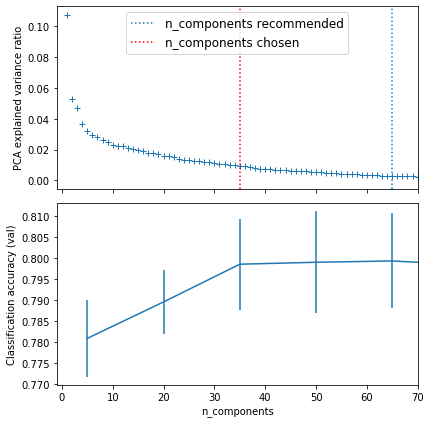

CPU times: user 3.79 s, sys: 1 s, total: 4.8 s
Wall time: 9.3 s


In [175]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1, class_weight = "balanced")
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits, y_digits = X_train, y_train
# X_digits, y_digits = X_res_over, y_res_over

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': range(5, 125, 15),
    'logistic__C': np.logspace(-6, 1, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components recommended')
ax0.axvline(35,
            linestyle=':', label='n_components chosen',
           c='r')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

Accuracy Score: 77.89%
_______________________________________________
Classification Report:	Precision Score: 36.68%
			Recall Score: 66.04%
			F1 score: 47.16%
_______________________________________________
Confusion Matrix: 
 [[1461  366]
 [ 109  212]]



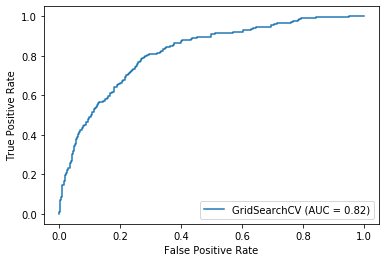

In [10]:
pred = search.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

svc_disp = plot_roc_curve(search, X_test, y_test)
plt.show()

In [11]:
# pd.DataFrame(pca.components_[:5],columns=X_train.columns)
pca_coef = pd.DataFrame(list(zip(pca.components_[0], X_train.columns)))
pca_coef.columns = ['coef', 'test']
pca_coef['coef'] = abs(pca_coef['coef'])
pca_coef.sort_values(by = 'coef', ascending = False).head(30)


,coef,test
60,0.222551,"('below_min', 'Hematocrit - Blood - Hematology')"
79,0.202430,"('above_max', 'Urea Nitrogen - Blood - Chemist..."
48,0.199273,"('below_min', 'Bicarbonate - Blood - Chemistry')"
49,0.199108,"('below_min', 'Calcium, Total - Blood - Chemis..."
63,0.170322,"('below_min', 'Platelet Count - Blood - Hemato..."
76,0.166567,"('above_max', 'Phosphate - Blood - Chemistry')"
86,0.162822,"('above_max', 'RDW - Blood - Hematology')"
71,0.162499,"('above_max', 'Chloride - Blood - Chemistry')"
14,0.161804,"('max', 'Anion Gap - Blood - Chemistry')"
74,0.159345,"('above_max', 'Glucose - Blood - Chemistry')"


## Recusive Feture Elimination - Recall

## Recusive Feature Elimination

In [20]:
%%time


import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

rfecv = RFECV(estimator=logReg, step=1, cv=StratifiedKFold(3),
              scoring='roc_auc', verbose = 1, n_jobs = -1)
rfecv.fit(X_train, y_train)


Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator wi

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=LogisticRegression(class_weight='balanced', max_iter=2000,
                                   penalty='l1', solver='liblinear'),
      n_jobs=-1, scoring='roc_auc', verbose=1)

Optimal number of features : 36


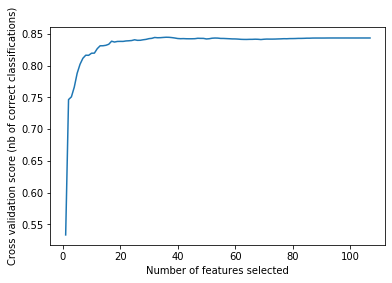

In [21]:
print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [22]:
rfecv.estimator_.coef_[0]

# X_train.iloc[:, rfecv.support_].columns

# X_train.columns#.iloc[rfecv.support_]
# rfecv.support_


array([-0.13440154, -0.12479411,  0.3895965 , -0.27491888,  0.37447051,
       -0.14740765,  0.35937008,  0.47971994,  0.17652524, -0.17119521,
       -0.16996199, -0.16917631,  0.17768621,  0.25842769, -0.14494371,
        0.20334452,  0.16731577, -0.31050069,  0.12830683, -0.22643316,
       -0.13236974,  0.17441841, -0.15194546, -0.12539896,  0.20306043,
       -0.26745402, -0.22814798, -0.21687562,  0.78723237,  0.3828946 ,
        0.16720343,  0.92632634,  0.28463023, -0.33855742,  0.38870766,
       -0.38084496])

In [23]:
est_coefs = pd.Series(rfecv.estimator_.coef_[0], index=X_train.iloc[:, rfecv.support_].columns)

sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0]#.head(50)


atherosclero                                              0.926326
age                                                       0.787232
('max', 'Bicarbonate - Blood - Chemistry')                0.479720
('min', 'Urea Nitrogen - Blood - Chemistry')              0.389596
ethnicity_BLACK/AFRICAN AMERICAN                          0.388708
diabetes                                                  0.382895
insurance_Medicaid                                        0.380845
('min', 'RDW - Blood - Hematology')                       0.374471
('max', 'Anion Gap - Blood - Chemistry')                  0.359370
ethnicity_ASIAN                                           0.338557
('below_min', 'Urea Nitrogen - Blood - Chemistry')        0.310501
renal_failure                                             0.284630
('min', 'Platelet Count - Blood - Hematology')            0.274919
('above_max', 'RDW - Blood - Hematology')                 0.267454
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')      0.25

In [24]:
X_train_trimmed = X_train.iloc[:, rfecv.support_]
# y_train_trimmed = y_train.iloc[:, rfecv.support_]

X_test_trimmed = X_test.iloc[:, rfecv.support_]
# y_test_trimmed = y_test.iloc[:, rfecv.support_]

In [25]:
from sklearn.base import clone

best_est = clone(rfecv.estimator_)
best_est.fit(X_train_trimmed, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='liblinear')

In [26]:
est_coefs = pd.Series(best_est.coef_[0], index=X_train.iloc[:, rfecv.support_].columns)

sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0]#.head(50)

atherosclero                                              0.926299
age                                                       0.787216
('max', 'Bicarbonate - Blood - Chemistry')                0.479699
('min', 'Urea Nitrogen - Blood - Chemistry')              0.389546
ethnicity_BLACK/AFRICAN AMERICAN                          0.388695
diabetes                                                  0.382909
insurance_Medicaid                                        0.380877
('min', 'RDW - Blood - Hematology')                       0.374550
('max', 'Anion Gap - Blood - Chemistry')                  0.359344
ethnicity_ASIAN                                           0.338564
('below_min', 'Urea Nitrogen - Blood - Chemistry')        0.310509
renal_failure                                             0.284557
('min', 'Platelet Count - Blood - Hematology')            0.274911
('above_max', 'RDW - Blood - Hematology')                 0.267549
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')      0.25

Accuracy Score: 75.79%
_______________________________________________
Classification Report:	Precision Score: 35.47%
			Recall Score: 75.70%
			F1 score: 48.31%
_______________________________________________
Confusion Matrix: 
 [[1385  442]
 [  78  243]]



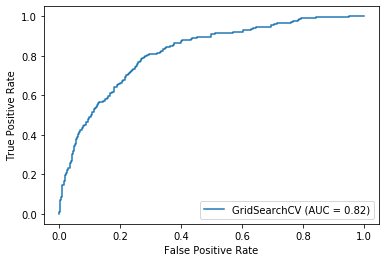

In [27]:
pred = rfecv.estimator_.predict(X_test_trimmed)

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

svc_disp = plot_roc_curve(search, X_test, y_test)
plt.show()

In [28]:
%%time

X_reduced = rfecv.transform(X_train)

# L1
params_log = [ {'C':np.logspace(-4, 3, 20)} ]
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params_log, cv = 5, scoring='roc_auc', n_jobs = -1)
grid_log.fit(X_reduced, y_train)
grid_log.best_score_

CPU times: user 365 ms, sys: 43.8 ms, total: 409 ms
Wall time: 780 ms


0.8547926153973927

In [29]:
grid_log.best_params_

{'C': 0.2069138081114788}

In [30]:
# X_train.iloc[:, rfecv.support_].columns

In [31]:
est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.iloc[:, rfecv.support_].columns)

sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs > 0].head(50)

atherosclero                                              0.862404
age                                                       0.778556
('max', 'Bicarbonate - Blood - Chemistry')                0.468853
('min', 'Urea Nitrogen - Blood - Chemistry')              0.375286
('min', 'RDW - Blood - Hematology')                       0.355932
('max', 'Anion Gap - Blood - Chemistry')                  0.347772
diabetes                                                  0.346278
ethnicity_BLACK/AFRICAN AMERICAN                          0.345565
insurance_Medicaid                                        0.315018
('below_min', 'Urea Nitrogen - Blood - Chemistry')        0.294113
('min', 'Platelet Count - Blood - Hematology')            0.266541
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')      0.256424
('above_max', 'RDW - Blood - Hematology')                 0.248824
ed_length                                                 0.218134
('above_max', 'Anion Gap - Blood - Chemistry')            0.21

In [167]:
sortedCoefs.shape

(36,)

In [32]:
X_test_reduced = rfecv.transform(X_test)

pred = grid_log.predict(X_test_reduced)

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Accuracy Score: 75.70%
_______________________________________________
Classification Report:	Precision Score: 35.37%
			Recall Score: 75.70%
			F1 score: 48.21%
_______________________________________________
Confusion Matrix: 
 [[1383  444]
 [  78  243]]



,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.164737,0.352468,0.673322,0.956386,0.474860,0.216045
1,0.165305,0.352874,0.673869,0.956386,0.475791,0.216350
2,0.165873,0.352332,0.672859,0.953271,0.476257,0.216102
3,0.166441,0.352332,0.672859,0.953271,0.476257,0.216102
4,0.167008,0.351585,0.671575,0.950156,0.476257,0.215700
5,0.167576,0.351585,0.671575,0.950156,0.476257,0.215700
6,0.168144,0.352194,0.672396,0.950156,0.477654,0.216159
7,0.168712,0.352397,0.672670,0.950156,0.478119,0.216312
8,0.169280,0.352397,0.672670,0.950156,0.478119,0.216312
9,0.169848,0.352601,0.672943,0.950156,0.478585,0.216466


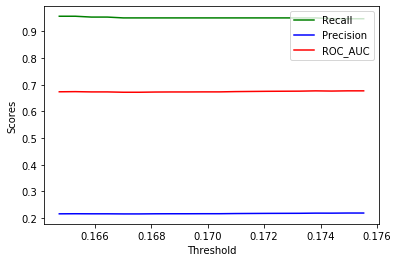

In [127]:
threshold_list = np.linspace(0.164737,0.175526,20)
change_threshold(grid_log, threshold_list, X_test_reduced)

## XGBoost

In [40]:
import xgboost as xgb
from xgboost import XGBClassifier

In [51]:
from sklearn.model_selection import StratifiedKFold
k_folds = StratifiedKFold(5)

In [70]:
%%time

xgtrain = xgb.DMatrix(X_reduced, label=y_train)

clf = xgb.XGBClassifier(max_depth = 105,
                n_estimators=850,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=0,
                n_jobs = -1)
xgb_param = clf.get_xgb_params()

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=500000, nfold=5, metrics=['auc'],
     early_stopping_rounds=5000, stratified=True, seed=0)



CPU times: user 6min 50s, sys: 3.17 s, total: 6min 53s
Wall time: 1min 44s


In [71]:
clf.set_params(n_estimators=cvresult.shape[0])

clf.fit(X_reduced, y_train, eval_metric='auc', verbose = True)

XGBClassifier(colsample_bytree=0.5, max_depth=105, min_child_weight=3,
              n_estimators=89, n_jobs=-1, seed=0, subsample=1.0)

In [72]:
pred = clf.predict(X_test_reduced, ntree_limit=cvresult.shape[0])
# pred
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Accuracy Score: 86.03%
_______________________________________________
Classification Report:	Precision Score: 56.44%
			Recall Score: 28.66%
			F1 score: 38.02%
_______________________________________________
Confusion Matrix: 
 [[1756   71]
 [ 229   92]]



## XGBoost with RFE

In [73]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [108]:
%%time

xgb = XGBClassifier(learning_rate=0.02, 
                    n_estimators=600, 
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(3),
              scoring='roc_auc', verbose = 1, n_jobs = -1)
rfecv.fit(X_train, y_train)

X_XGB_reduced = rfecv.transform(X_train)

Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator wi

In [168]:
X_XGB_reduced.shape

(6443, 60)

In [109]:
%%time

xgb = XGBClassifier(learning_rate=0.02, 
#                     n_estimators=600, 
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': range(550,900,50),
        'max_depth': range(90,150,15)
        }

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=0 )

random_search.fit(X_XGB_reduced, y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:  3.8min remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


CPU times: user 25.6 s, sys: 419 ms, total: 26 s
Wall time: 4min 26s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(learning_rate=0.02, nthread=1,
                                           silent=True),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': range(90, 150, 15),
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(550, 900, 50),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring='roc_auc', verbose=3)

In [110]:
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_depth=90,
              min_child_weight=5, n_estimators=600, nthread=1, silent=True,
              subsample=0.8)

In [111]:
# Get most important features
tree_final = random_search.best_estimator_
feature_importance = tree_final.feature_importances_
feature_importance = list(zip(X_train.columns, feature_importance))

feature_importance.sort(key = lambda x: x[1], reverse = True)
feature_importance

[("('below_min', 'Bicarbonate - Blood - Chemistry')", 0.05281621),
 ("('abn_percent', 'Chloride - Blood - Chemistry')", 0.047526844),
 ("('abn_percent', 'Calcium, Total - Blood - Chemistry')", 0.04134939),
 ("('below_min', 'Phosphate - Blood - Chemistry')", 0.033429645),
 ("('below_min', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')",
  0.02567526),
 ("('max', 'Hematocrit - Blood - Hematology')", 0.024168396),
 ("('abn_percent', 'MCH - Blood - Hematology')", 0.023447003),
 ("('below_min', 'Troponin T - Blood - Chemistry')", 0.021248553),
 ("('below_min', 'Urea Nitrogen - Blood - Chemistry')", 0.02029735),
 ("('abn_percent', 'Estimated GFR (MDRD equation) - Blood - Chemistry')",
  0.018996218),
 ("('min', 'Troponin T - Blood - Chemistry')", 0.01799234),
 ("('min', 'White Blood Cells - Blood - Hematology')", 0.017296018),
 ("('abn_percent', 'Potassium - Blood - Chemistry')", 0.017278396),
 ("('abn_percent', 'MCV - Blood - Hematology')", 0.01679339),
 ("('max', 'Anion Gap - Blood -

In [113]:
X_XGB_test_reduced = rfecv.transform(X_test)

pred = tree_final.predict(X_XGB_test_reduced, ntree_limit=cvresult.shape[0])

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Accuracy Score: 86.50%
_______________________________________________
Classification Report:	Precision Score: 63.03%
			Recall Score: 23.36%
			F1 score: 34.09%
_______________________________________________
Confusion Matrix: 
 [[1783   44]
 [ 246   75]]



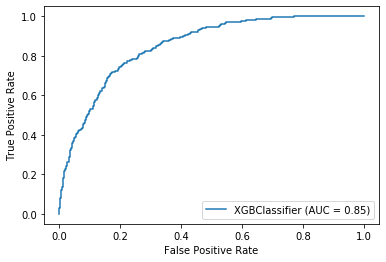

In [115]:
svc_disp = plot_roc_curve(tree_final, X_XGB_test_reduced, y_test)
plt.show()

In [123]:
pred_thres = np.where(random_search.best_estimator_.predict_proba(X_XGB_test_reduced)[:,1]>0.05275,1,0)

print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred_thres)}\n")


Confusion Matrix: 
 [[1071  756]
 [  30  291]]



,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.030526,0.384089,0.713383,0.962617,0.538641,0.239907
1,0.030706,0.384089,0.713383,0.962617,0.538641,0.239907
2,0.030886,0.384328,0.713657,0.962617,0.539106,0.240093
3,0.031066,0.384040,0.712920,0.959502,0.540037,0.240062
4,0.031246,0.384519,0.713467,0.959502,0.540968,0.240437
5,0.031426,0.384760,0.713741,0.959502,0.541434,0.240625
6,0.031606,0.385000,0.714015,0.959502,0.541899,0.240813
7,0.031786,0.384471,0.713004,0.956386,0.542365,0.240596
8,0.031966,0.385194,0.713825,0.956386,0.543762,0.241163
9,0.032146,0.384422,0.712541,0.953271,0.543762,0.240755


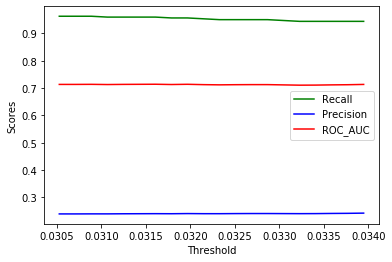

In [129]:
threshold_list = np.linspace(0.030526,0.033947,20)
change_threshold(random_search, threshold_list, X_XGB_test_reduced)

## RFE and NearMiss with XGBoost

In [99]:
%%time

xgb = XGBClassifier(learning_rate=0.02, 
#                     n_estimators=600, 
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(3),
              scoring='roc_auc', verbose = 1, n_jobs = -1)
rfecv.fit(X_res_under, y_res_under)

X_XGB_reduced = rfecv.transform(X_res_under)

Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator wi

In [101]:
%%time

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': range(550,900,50),
        'max_depth': range(90,150,15)
        }

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=0 )

random_search.fit(X_XGB_reduced, y_res_under)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:   26.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.4s finished


CPU times: user 5.59 s, sys: 47.3 ms, total: 5.64 s
Wall time: 32.9 s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(learning_rate=0.02, nthread=1,
                                           silent=True),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': range(90, 150, 15),
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(550, 900, 50),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring='roc_auc', verbose=3)

Accuracy Score: 49.02%
_______________________________________________
Classification Report:	Precision Score: 21.75%
			Recall Score: 92.83%
			F1 score: 35.25%
_______________________________________________
Confusion Matrix: 
 [[ 755 1072]
 [  23  298]]



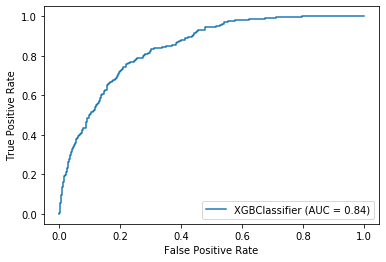

In [103]:
X_XGB_test_reduced = rfecv.transform(X_test)

pred = random_search.best_estimator_.predict(X_XGB_test_reduced, ntree_limit=cvresult.shape[0])

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

svc_disp = plot_roc_curve(tree_final, X_test_reduced, y_test)
plt.show()

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.308506,0.606185,1.000000,0.330074,0.182386
1,0.064444,0.446556,0.758628,0.878505,0.674581,0.299363
2,0.118889,0.500501,0.772276,0.778816,0.767691,0.368732
3,0.173333,0.529833,0.765061,0.691589,0.816574,0.429400
4,0.227778,0.515354,0.736310,0.601246,0.831006,0.450935
5,0.282222,0.499266,0.712800,0.529595,0.841248,0.472222
6,0.336667,0.478191,0.689479,0.461059,0.849628,0.496644
7,0.391111,0.469965,0.676514,0.414330,0.860335,0.542857
8,0.445556,0.458647,0.665674,0.380062,0.865922,0.578199
9,0.500000,0.427419,0.646226,0.330218,0.867784,0.605714


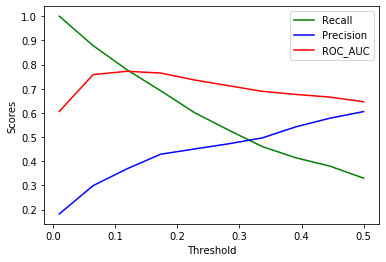

In [119]:
threshold_list = np.linspace(0.01,0.5,10)
change_threshold(random_search, threshold_list, X_XGB_test_reduced)

## Future Predictions with XGBoost

In [147]:
# sample_labs_imputed = pd.read_pickle("data/sample_labs_imputed.pkl")
sample_labs_imputed = pd.read_csv('./data/sample_labs_imputed.csv.gz', compression='gzip')

In [151]:
sample_labs_imputed.pos_subj.value_counts()

0.0    6448
1.0    1167
Name: pos_subj, dtype: int64

In [152]:
model_cols = ~sample_labs_imputed.columns.isin(['subject_id', 'hadm_id', 'Unnamed: 0', 'pos_subj'])

hadm_features = sample_labs_imputed.loc[:, model_cols]
hadm_target = sample_labs_imputed.loc[:, 'pos_subj']

In [153]:
X_train, X_test, y_train, y_test = train_test_split(hadm_features, hadm_target, stratify=hadm_target, random_state=0)



In [155]:
%%time

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': range(550,900,50),
        'max_depth': range(90,150,15)
        }

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=0 )

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:  3.8min remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


CPU times: user 27.5 s, sys: 191 ms, total: 27.7 s
Wall time: 4min 26s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(learning_rate=0.02, nthread=1,
                                           silent=True),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': range(90, 150, 15),
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(550, 900, 50),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring='roc_auc', verbose=3)

Accuracy Score: 84.82%
_______________________________________________
Classification Report:	Precision Score: 52.94%
			Recall Score: 9.25%
			F1 score: 15.74%
_______________________________________________
Confusion Matrix: 
 [[1588   24]
 [ 265   27]]



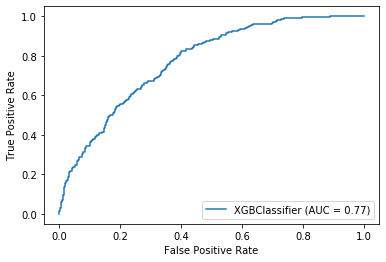

In [157]:
# X_XGB_test_reduced = rfecv.transform(X_test)

pred = random_search.best_estimator_.predict(X_test, ntree_limit=cvresult.shape[0])

print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print("Classification Report:", end='')
print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

svc_disp = plot_roc_curve(random_search.best_estimator_, X_test, y_test)
plt.show()

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.033500,0.351828,0.662913,0.955479,0.460084,0.215611
1,0.033611,0.352273,0.663534,0.955479,0.461134,0.215944
2,0.033722,0.351232,0.661821,0.952055,0.460609,0.215337
3,0.033833,0.351232,0.661821,0.952055,0.460609,0.215337
4,0.033944,0.351899,0.662752,0.952055,0.462185,0.215839
5,0.034056,0.351077,0.661350,0.948630,0.462185,0.215397
6,0.034167,0.351077,0.661350,0.948630,0.462185,0.215397
7,0.034278,0.352417,0.663211,0.948630,0.465336,0.216406
8,0.034389,0.351592,0.661809,0.945205,0.465336,0.215962
9,0.034500,0.351592,0.661809,0.945205,0.465336,0.215962


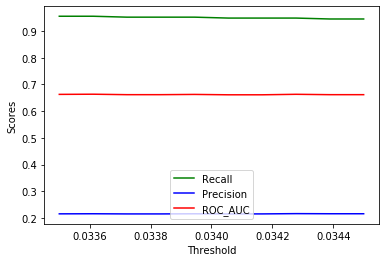

In [165]:
threshold_list = np.linspace(0.0335,0.0345,10)
change_threshold(random_search, threshold_list, X_test)

In [166]:
# Get most important features
tree_final = random_search.best_estimator_
feature_importance = tree_final.feature_importances_
feature_importance = list(zip(X_train.columns, feature_importance))

feature_importance.sort(key = lambda x: x[1], reverse = True)
feature_importance

[('atherosclero', 0.043728404),
 ('age', 0.037398387),
 ('mean UreaNitrogen', 0.027692975),
 ('above_max UreaNitrogen', 0.025261048),
 ('hypertension', 0.020793442),
 ('below_min Creatinine', 0.018034616),
 ('diabetes', 0.017438713),
 ('mean Creatinine', 0.0171105),
 ('mean RDW', 0.016981374),
 ('above_max Creatinine', 0.01603859),
 ('below_min UreaNitrogen', 0.01547192),
 ('arrhythmia', 0.015305938),
 ('below_min Bicarbonate', 0.015050877),
 ('below_min MCH', 0.014985735),
 ('mean Bicarbonate', 0.014708021),
 ('mean MCHC', 0.014433593),
 ('above_max INR(PT)', 0.0141669875),
 ('above_max RDW', 0.014036348),
 ('above_max PT', 0.014029851),
 ('below_min Phosphate', 0.013717574),
 ('ethnicity_black/african american', 0.013650082),
 ('above_max BilirubinTotal', 0.013649977),
 ('mean MCH', 0.013637771),
 ('above_max PTT', 0.013630871),
 ('mean INR(PT)', 0.013504067),
 ('mean Phosphate', 0.013494982),
 ('above_max Chloride', 0.013493264),
 ('mean Chloride', 0.013462126),
 ('mean Hematocrit',

In [170]:
len(feature_importance)

78